# 03_city_steps – City Steps by Neighborhood

This notebook loads the City Steps dataset, aggregates steps by neighborhood, 
computes a `steps_score`, and makes a couple of simple visualizations.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path

PROJECT_DIR = Path(".")
CSV_PATH = PROJECT_DIR / "LOCAL_CITY_STEPS_CSV_PATH.csv"
NEIGHBORHOODS_SHP = PROJECT_DIR / "neighborhoods" / "Neighborhoods_.shp"
PROCESSED_DIR = PROJECT_DIR / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_CSV = PROCESSED_DIR / "steps_scores.csv"

In [10]:
steps_raw = pd.read_csv(CSV_PATH)

required_cols = ["id", "number_of_steps", "neighborhood"]
missing_cols = [c for c in required_cols if c not in steps_raw.columns]
if missing_cols:
    raise ValueError(f"Missing columns in CSV: {missing_cols}")

steps_clean = steps_raw[required_cols].copy()
steps_clean["number_of_steps"] = pd.to_numeric(steps_clean["number_of_steps"], errors="coerce")
steps_clean = steps_clean.dropna(subset=["neighborhood", "number_of_steps"])
steps_clean = steps_clean[steps_clean["number_of_steps"] > 0].copy()

In [11]:
neigh_area = gpd.read_file(NEIGHBORHOODS_SHP, ignore_geometry=True)
if not {"hood", "sqmiles"}.issubset(neigh_area.columns):
    raise ValueError("Shapefile must contain 'hood' and 'sqmiles' columns")
neigh_area = neigh_area[["hood", "sqmiles"]].copy()

In [12]:
agg_df = (
    steps_clean.groupby("neighborhood")
    .agg(
        total_steps=("number_of_steps", "sum"),
        stair_count=("id", "count"),
    )
    .reset_index()
)

agg_df = agg_df.merge(neigh_area, left_on="neighborhood", right_on="hood", how="left")
agg_df = agg_df.dropna(subset=["sqmiles"]).copy()

agg_df["steps_density"] = agg_df["total_steps"] / agg_df["sqmiles"]
agg_df["stairs_density"] = agg_df["stair_count"] / agg_df["sqmiles"]

steps_density_max = agg_df["steps_density"].max()
stairs_density_max = agg_df["stairs_density"].max()

if steps_density_max > 0:
    agg_df["steps_density_norm"] = agg_df["steps_density"] / steps_density_max
else:
    agg_df["steps_density_norm"] = 0.0

if stairs_density_max > 0:
    agg_df["stairs_density_norm"] = agg_df["stairs_density"] / stairs_density_max
else:
    agg_df["stairs_density_norm"] = 0.0

In [13]:
avg = agg_df["total_steps"] / agg_df["stair_count"]

avg_max = avg.max()
avg_min = avg.min()

if avg_max > avg_min:
    avg_norm = (avg - avg_min) / (avg_max - avg_min)
else:
    avg_norm = pd.Series(0.5, index=agg_df.index)

short_score = 1 - avg_norm

agg_df["avg_steps_per_stair"] = avg
agg_df["avg_steps_per_stair_norm"] = avg_norm
agg_df["short_stair_score"] = short_score
agg_df["compact_stair_score"] = short_score * agg_df["stairs_density_norm"]

agg_df = agg_df.sort_values("compact_stair_score", ascending=False).reset_index(drop=True)

In [14]:
cols_to_save = [
    "neighborhood",
    "total_steps",
    "stair_count",
    "sqmiles",
    "steps_density",
    "stairs_density",
    "steps_density_norm",
    "stairs_density_norm",
    "avg_steps_per_stair",
    "avg_steps_per_stair_norm",
    "short_stair_score",
    "compact_stair_score",
]
agg_df[cols_to_save].to_csv(OUTPUT_CSV, index=False)
OUTPUT_CSV

PosixPath('data/processed/steps_scores.csv')

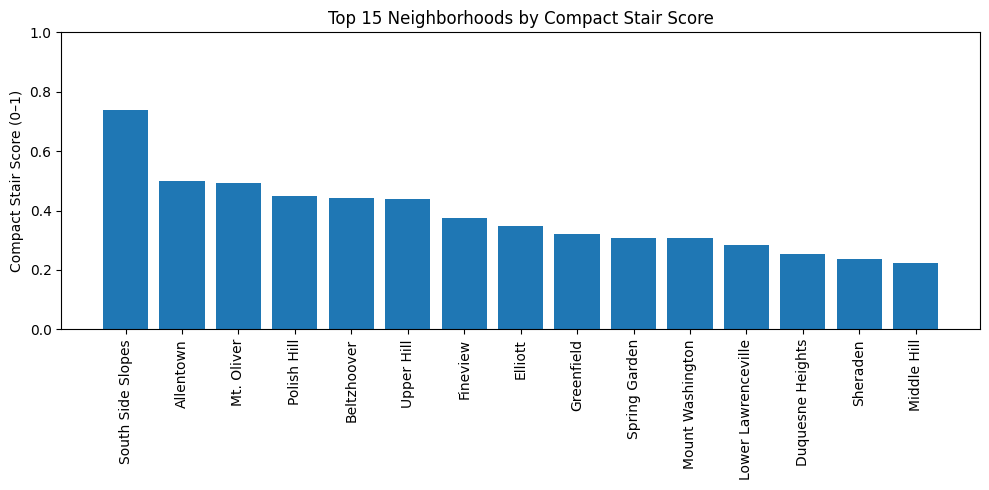

In [15]:
top15_compact = agg_df.nlargest(15, "compact_stair_score")
plt.figure(figsize=(10, 5))
plt.bar(top15_compact["neighborhood"], top15_compact["compact_stair_score"])
plt.xticks(rotation=90)
plt.ylabel("Compact Stair Score (0–1)")
plt.ylim(0, 1)
plt.title("Top 15 Neighborhoods by Compact Stair Score")
plt.tight_layout()
plt.show()